In [1]:
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from preprocessing import PreprocessorBase
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

2023-12-27 07:38:57.285631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Basic Preprocesing

In [2]:
cleaner = PreprocessorBase()

[nltk_data] Downloading package punkt to /home/fahmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_json("../dataset/houses-9k.json", lines=True)
df.head(2)

,id,price,installment,address,tags,description,specs,facilities,agent,images,url
0,hos13819879,295000.0,21,"Sentul City, Bogor","[Cash Keras, One Gate System]","Rumah siap masuk dengan style englang house,be...","{'Kamar Tidur': '3', 'Kamar Mandi': '4', 'Luas...","[Jalur Telepon, Taman, Tempat Jemuran, Akses P...","{'name': 'Heri Andrian', 'url': 'https://www.r...",[https://picture.rumah123.com/r123-images/720x...,https://www.rumah123.com/properti/bogor/hos138...
1,hos13868613,11000.0,7,"Bogor Barat, Bogor","[Bisa Nego, Cash Keras/KPR]","Dijual rumah seken terawat, bebas banjir, loka...","{'Kamar Tidur': '2', 'Kamar Mandi': '1', 'Luas...","[Keamanan, Taman, Tempat Jemuran, Keamanan 24 ...","{'name': 'PASHOUSES ID', 'url': 'https://www.r...",[https://picture.rumah123.com/r123-images/720x...,https://www.rumah123.com/properti/bogor/hos138...


In [4]:
df["kecamatan"] = cleaner.derive_kecamatan(df)
df = cleaner.transform_dict_col(df, "specs", "spec_")
df = cleaner.transform_list_col(df, "tags", return_embeddings=True, binarize=True)
df = cleaner.transform_list_col(df, "facilities", return_embeddings=True, binarize=True, split_fun=cleaner.dedupe_facilities)
df = cleaner.infer_spec_cols(df, prefix="spec_")
df = df.drop(columns=['id', 'images', 'installment', 'address', 'description', 'specs', 'agent', 'url', 'spec_id_iklan'])

df = cleaner.drop_features_by_nan(df, threshold=0.7)

FILLNA_CAT_COLS = df.select_dtypes(include=['object']).columns.tolist()
df = df.fillna({k: "[UNK]" for k in FILLNA_CAT_COLS})

FILLNA_NUM_COLS = df.select_dtypes(exclude=['object']).columns.tolist()
df = df.fillna({k: df[k].mean() for k in FILLNA_NUM_COLS})

df["price"] = np.log(df["price"])

df.head(2)

,price,tags,facilities,kecamatan,spec_kamar_tidur,spec_kamar_mandi,spec_luas_tanah,spec_luas_bangunan,spec_tipe_properti,spec_sertifikat,spec_daya_listrik,spec_ruang_makan,spec_ruang_tamu,spec_kondisi_perabotan,spec_jumlah_lantai,spec_terjangkau_internet,spec_hook,spec_kondisi_properti
0,12.594731,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, ...",Sentul City,3.0,4.0,400.0,150.0,Rumah,SHM - Sertifikat Hak Milik,2200.0,Tidak,Tidak,Unfurnished,2.0,Ya,Tidak,Bagus
1,9.305651,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",Bogor Barat,2.0,1.0,138.0,105.0,Rumah,HGB - Hak Guna Bangunan,2200.0,Ya,Ya,Unfurnished,1.0,Tidak,Tidak,Bagus


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9047 entries, 0 to 9046
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     9047 non-null   float64
 1   tags                      9047 non-null   object 
 2   facilities                9047 non-null   object 
 3   kecamatan                 9047 non-null   object 
 4   spec_kamar_tidur          9047 non-null   float64
 5   spec_kamar_mandi          9047 non-null   float64
 6   spec_luas_tanah           9047 non-null   float64
 7   spec_luas_bangunan        9047 non-null   float64
 8   spec_tipe_properti        9047 non-null   object 
 9   spec_sertifikat           9047 non-null   object 
 10  spec_daya_listrik         9047 non-null   float64
 11  spec_ruang_makan          9047 non-null   object 
 12  spec_ruang_tamu           9047 non-null   object 
 13  spec_kondisi_perabotan    9047 non-null   object 
 14  spec_jum

## Dataset Building

In [6]:
def df_to_ds(dataframe, shuffle=True, batch_size=64):
  # copy dataframe
  df = dataframe.copy()

  # extract labels
  labels = df.pop('price')

  # create tf dataset
  df["tags"] = df["tags"].apply(lambda x: np.array(x))
  df["facilities"] = df["facilities"].apply(lambda x: np.array(x))

  dc = {}
  for k, v in df.items():
    if k in ["tags", "facilities"]:
      dc[k] = np.array([np.array(x) for x in v.values])
    else:
      dc[k] = v.values
  
  ds = tf.data.Dataset.from_tensor_slices((dc, labels))

  # shuffle
  if shuffle:
      ds = ds.shuffle(buffer_size=len(dataframe))

  # batch and prefetch
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)

  return ds

In [26]:
df_clean = df[
  [
  'price', 
  'tags', 
  'facilities', 
  'kecamatan', 
  'spec_kamar_tidur', 
  'spec_kamar_mandi', 
  'spec_luas_tanah', 
  'spec_luas_bangunan', 
#   'spec_tipe_properti', 
#   'spec_sertifikat', 
  'spec_daya_listrik', 
  'spec_ruang_makan', 
  'spec_ruang_tamu', 
#   'spec_kondisi_perabotan',
  'spec_jumlah_lantai', 
  'spec_terjangkau_internet', 
#   'spec_hook', 
#   'spec_kondisi_properti'
  ]
]

df_clean.sample(1)

,price,tags,facilities,kecamatan,spec_kamar_tidur,spec_kamar_mandi,spec_luas_tanah,spec_luas_bangunan,spec_daya_listrik,spec_ruang_makan,spec_ruang_tamu,spec_jumlah_lantai,spec_terjangkau_internet
335,9.740969,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",Tanah Baru,5.0,3.0,114.0,100.0,3500.0,Ya,Ya,2.0,Ya


In [27]:
df_train, df_test = train_test_split(df_clean, train_size=0.75, random_state=42)

ds_train = df_to_ds(df_train)
ds_test = df_to_ds(df_test)

In [28]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = tf.keras.layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def get_category_encoding_layer(name, dataset, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  index = tf.keras.layers.StringLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

## Modelling

In [30]:
all_inputs = []
all_features = []

# encode numerical features
num_features = []
num_cols = set(df_clean.select_dtypes(include=['float64']).columns.tolist()) - set(["price"])
for col in num_cols:
  input_col = tf.keras.Input(shape=(1,), name=col)
  normalization_layer = get_normalization_layer(col, ds_train)
  encoded_col = normalization_layer(input_col)

  all_inputs.append(input_col)
  num_features.append(encoded_col)

# encode categorical features
cat_features = []
cat_cols = set(df_clean.select_dtypes(include=['object']).columns.tolist()) - set(["tags", "facilities"])
for col in cat_cols:
  input_col = tf.keras.Input(shape=(1,), name=col, dtype="string")
  encoding_layer = get_category_encoding_layer(col, ds_train, max_tokens=100)
  encoded_col = encoding_layer(input_col)

  all_inputs.append(input_col)
  cat_features.append(encoded_col)

# input for multi-hot encoded features
mul_features = []
mul_cols = ["tags", "facilities"]
for col in mul_cols:
    input_tags = tf.keras.Input(shape=(len(df[col][0]),), name=col, dtype="int32")
    encoded_tags = tf.cast(input_tags, tf.float32)

    all_inputs.append(input_tags)
    mul_features.append(encoded_tags)


In [39]:
# hidden layer for embedding
categorical_layer = tf.keras.layers.concatenate(cat_features)
categorical_layer = tf.keras.layers.Dense(128, activation="relu")(categorical_layer)
categorical_layer = tf.keras.layers.Dense(64, activation="relu")(categorical_layer)

# hidden layer for multi-hot encoded features
multi_hot_layer = tf.keras.layers.concatenate(mul_features)
multi_hot_layer = tf.keras.layers.Dense(128, activation="relu")(multi_hot_layer)
multi_hot_layer = tf.keras.layers.Dense(64, activation="relu")(multi_hot_layer)

# hidden layer for all features
all_features = tf.keras.layers.concatenate([categorical_layer, multi_hot_layer] + num_features)
x = tf.keras.layers.Dense(256, activation="relu")(all_features)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1)(x)

# create model
model = tf.keras.Model(all_inputs, output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 kecamatan (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 spec_ruang_makan (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 spec_ruang_tamu (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                            

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.R2Score()])

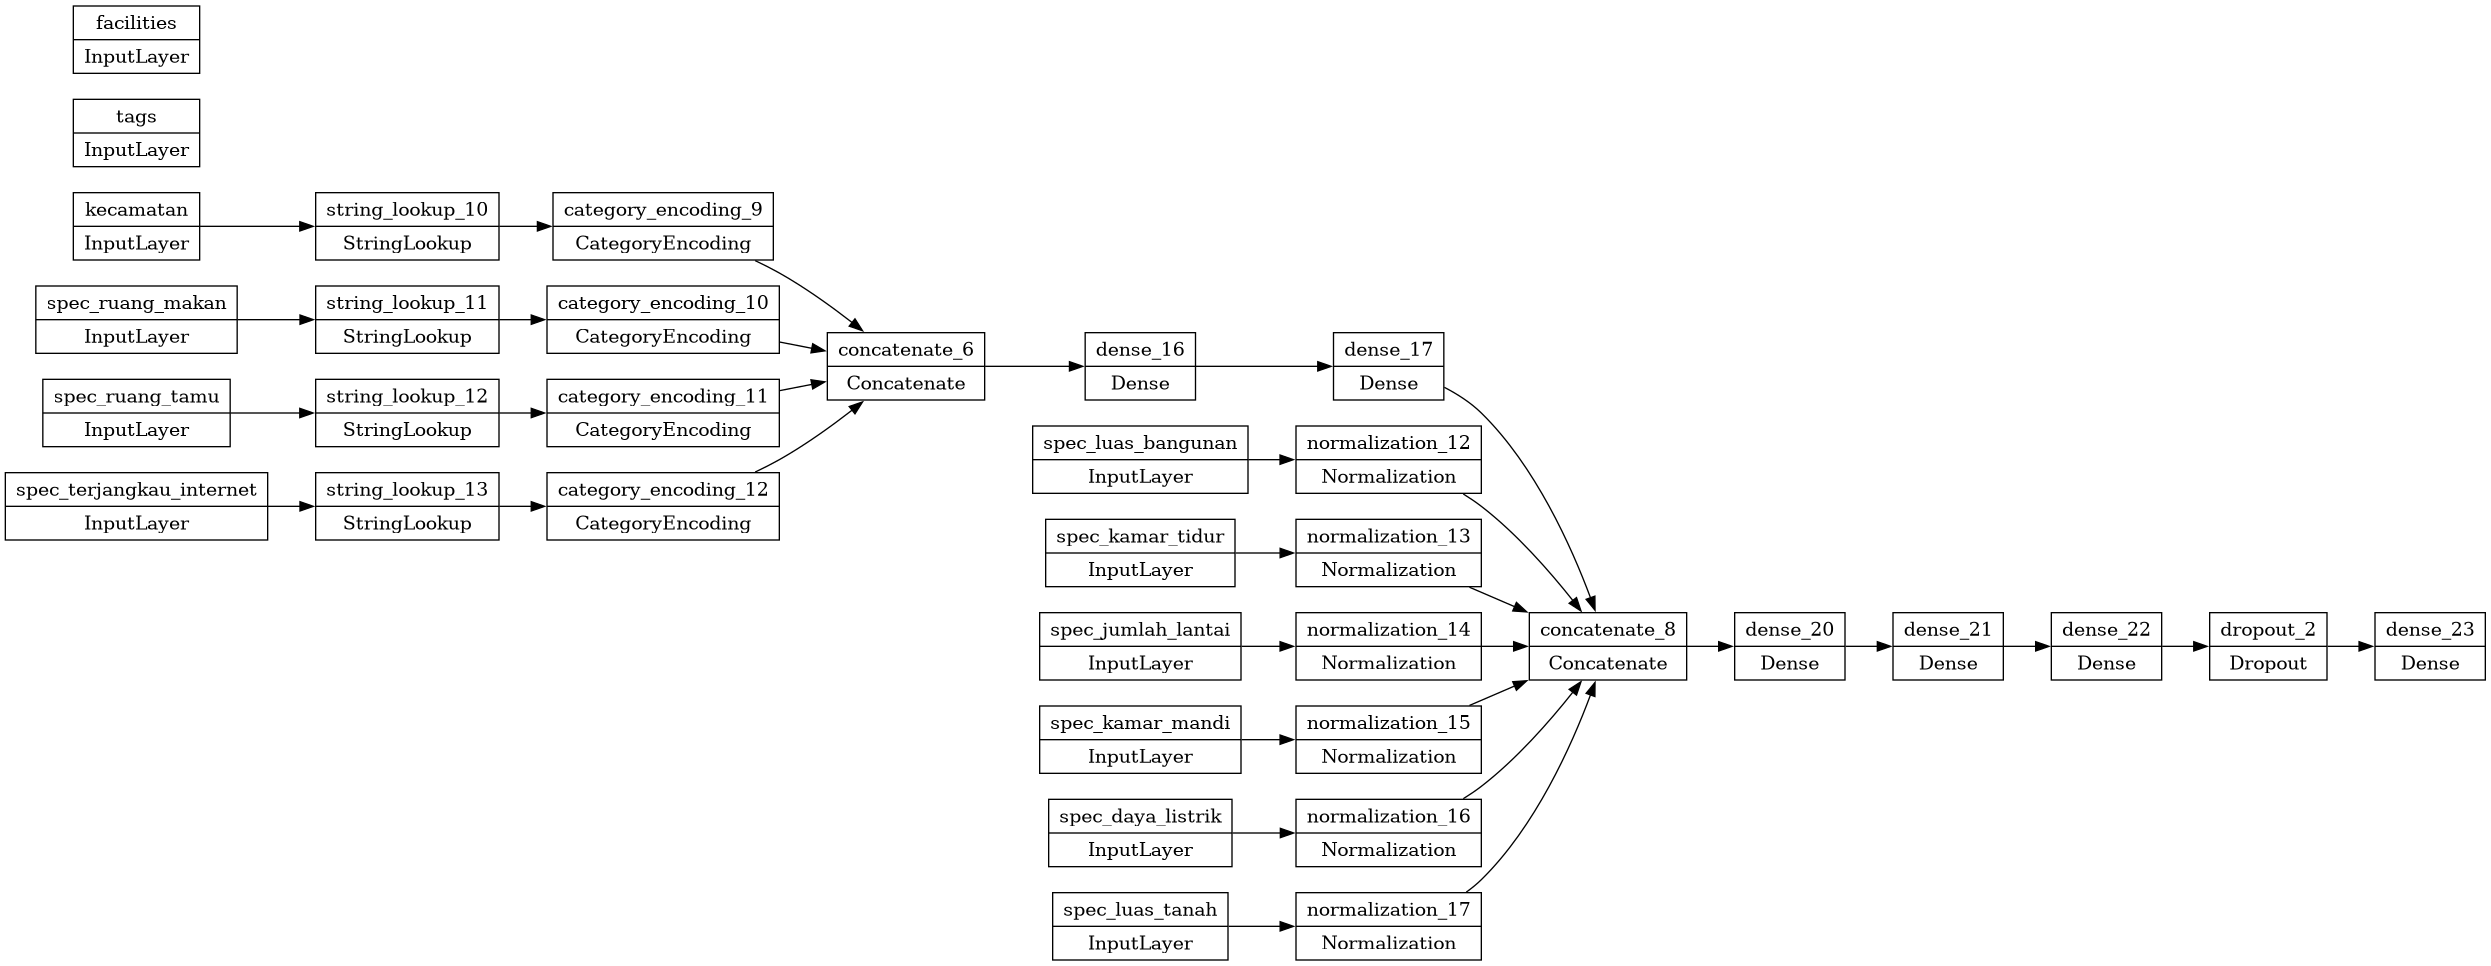

In [41]:
tf.keras.utils.plot_model(model, rankdir="LR")

In [42]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

H = model.fit(ds_train, epochs=100, validation_data=ds_test, callbacks=[tensorboard_callback])

Epoch 1/100


107/107 [==============================] - 2s 7ms/step - loss: 18.0891 - mean_absolute_error: 2.5912 - r2_score: -2.1316 - val_loss: 3.7577 - val_mean_absolute_error: 1.5877 - val_r2_score: 0.3591
Epoch 2/100
107/107 [==============================] - 0s 4ms/step - loss: 4.3067 - mean_absolute_error: 1.5321 - r2_score: 0.2544 - val_loss: 2.9493 - val_mean_absolute_error: 1.3244 - val_r2_score: 0.4970
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: 3.3479 - mean_absolute_error: 1.4070 - r2_score: 0.4204 - val_loss: 2.6849 - val_mean_absolute_error: 1.2848 - val_r2_score: 0.5421
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 3.1288 - mean_absolute_error: 1.3615 - r2_score: 0.4583 - val_loss: 4.2326 - val_mean_absolute_error: 1.7404 - val_r2_score: 0.2781
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 3.1311 - mean_absolute_error: 1.3697 - r2_score: 0.4579 - val_loss: 2.8029 - val_mean_absolute_error: 1.344

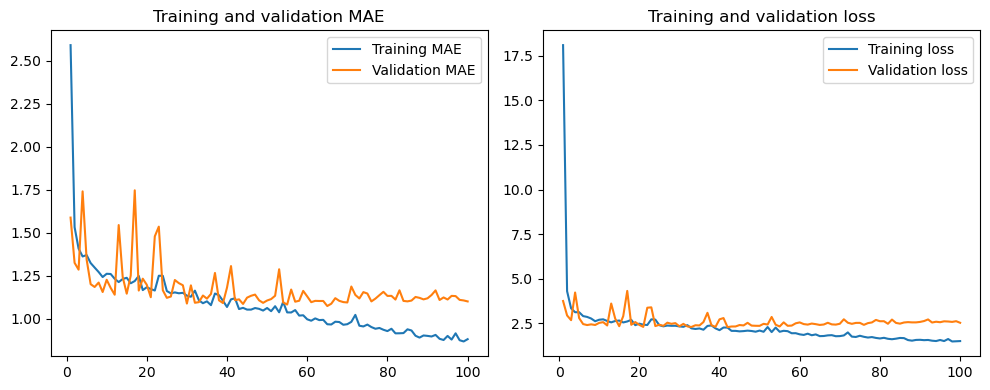

In [44]:
epochs = range(1, len(H.history["loss"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(epochs, H.history["mean_absolute_error"], label='Training MAE')
ax1.plot(epochs, H.history["val_mean_absolute_error"], label='Validation MAE')
ax1.set_title('Training and validation MAE')
ax1.legend()

ax2.plot(epochs, H.history["loss"], label='Training loss')
ax2.plot(epochs, H.history["val_loss"], label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

fig.tight_layout()
plt.show()

In [45]:
y_pred = model.predict(ds_test)
y_test = df_test["price"].values.reshape(-1, 1)

print("R2", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MAPE", mean_absolute_percentage_error(y_test, y_pred))

pd.DataFrame({
  "Data": ["Actual", "Prediction", "Train"],
  "Means": [y_test.mean(), y_pred.mean(), df_train["price"].mean()],
  "Stddev": [y_test.std(), y_pred.std(), df_train["price"].std()],
  "Var": [y_test.var(), y_pred.var(), df_train["price"].var()]
})

36/36 [==============================] - 0s 2ms/step
R2 -0.8229372294627104
MSE 10.688704911012566
RMSE 3.2693584861578833
MAE 2.6715818881811755
MAPE 0.33388578045121386


,Data,Means,Stddev,Var
0,Actual,8.531080,2.421457,5.863452
1,Prediction,8.411201,2.129489,4.534725
2,Train,8.557243,2.403569,5.777142


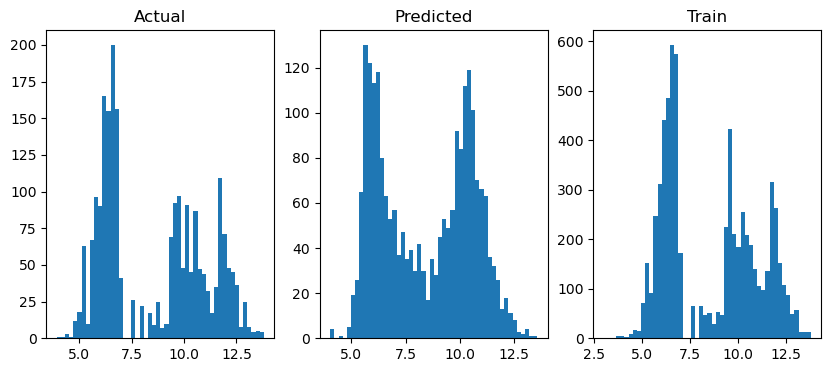

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

ax1.hist(y_test, bins=50)
ax1.set_title("Actual")

ax2.hist(y_pred, bins=50)
ax2.set_title("Predicted")

y_train = df_train["price"].values.reshape(-1, 1)
ax3.hist(y_train, bins=50)
ax3.set_title("Train")

plt.show()

(3.4378920135535056, 14.30443163531155, 3.5543811321258545, 14.036579370498657)

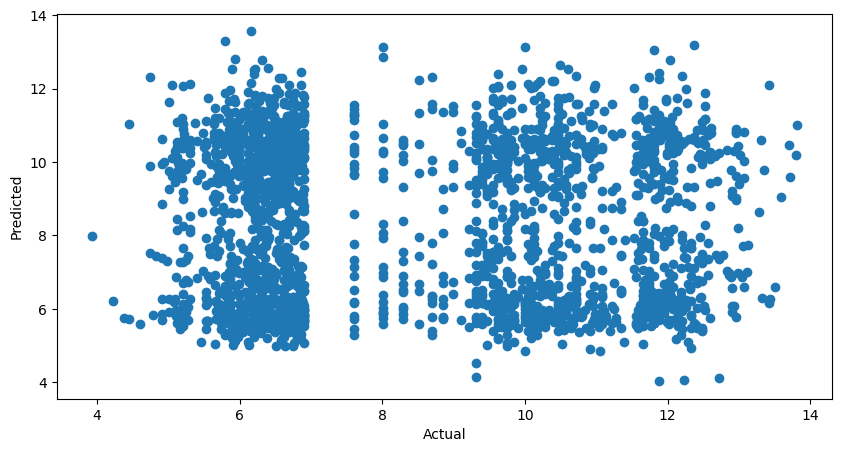

In [47]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.axis("tight")